## Adult Data

** Import the libraries you usually use for data analysis.**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot

In [96]:
# parameters
n_seed = 111
n_centroids = 2
n_init = 10

In [97]:
df = pd.read_csv('./clean_data/adult_train.txt',index_col=False)
labels = df['income']
df = df.drop('income',axis=1)

In [5]:
print(confusion_matrix(labels, kmeans.labels_))
print(classification_report(labels, kmeans.labels_))

[[13957  8697]
 [ 2343  5165]]
             precision    recall  f1-score   support

          0       0.86      0.62      0.72     22654
          1       0.37      0.69      0.48      7508

avg / total       0.74      0.63      0.66     30162



In [98]:
# normalize only continuous numeric columns
a = df[['age','hr_per_week']]
df[['age','hr_per_week']] = (a - a.mean()) / np.std(a)

### Apply K Means

In [109]:
kmeans = KMeans(n_clusters=n_centroids, random_state=n_seed, n_init=n_init)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [108]:
print(confusion_matrix(labels,kmeans.labels_))
print(classification_report(labels,kmeans.labels_))

[[13703  8951]
 [ 1030  6478]]
             precision    recall  f1-score   support

          0       0.93      0.60      0.73     22654
          1       0.42      0.86      0.56      7508

avg / total       0.80      0.67      0.69     30162



### Apply EM

In [101]:
from sklearn.mixture import GaussianMixture

In [102]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init)
gm.fit(df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=10, precisions_init=None,
        random_state=111, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [103]:
gm_labels = gm.predict(df)

In [104]:
print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[ 9392 13262]
 [  429  7079]]
             precision    recall  f1-score   support

          0       0.96      0.41      0.58     22654
          1       0.35      0.94      0.51      7508

avg / total       0.80      0.55      0.56     30162



### Apply PCA to Normalized Data 

In [9]:
from sklearn.decomposition import PCA

In [10]:
#fig = plt.figure(figsize=(7,5))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pca3[:,0], pca3[:,1],pca3[:,2],c=df['income'],cmap='plasma')

In [11]:
n_features = len(df.columns)

## Try it on whole data

In [12]:
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(df)
pca_n = pca_all.transform(df)
#pca_all.n_components_


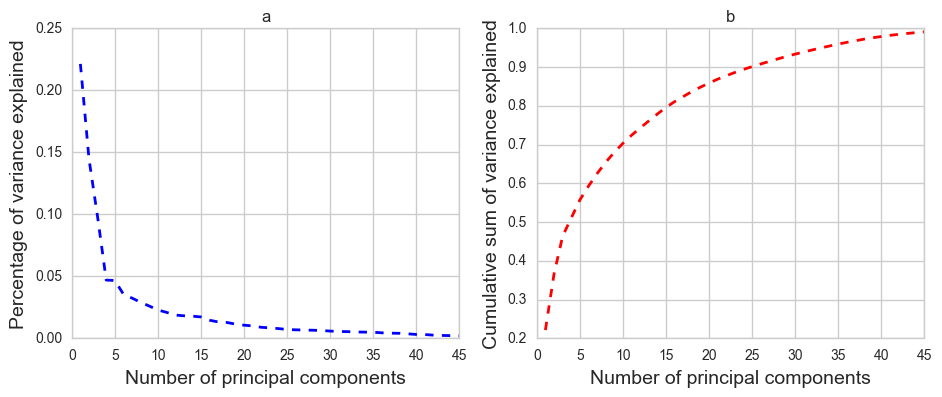

In [13]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y)) + 1

# plot pca
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '--',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '--',lw=2.0, color='red')

### Apply k-means to PCA output

In [14]:
kmeans.fit(pca_n)
print(confusion_matrix(labels,kmeans.labels_))
print(classification_report(labels,kmeans.labels_))

[[13894  8760]
 [ 1078  6430]]
             precision    recall  f1-score   support

          0       0.93      0.61      0.74     22654
          1       0.42      0.86      0.57      7508

avg / total       0.80      0.67      0.70     30162



### Apply EM to PCA output

In [105]:
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[ 9363 13291]
 [  446  7062]]
             precision    recall  f1-score   support

          0       0.95      0.41      0.58     22654
          1       0.35      0.94      0.51      7508

avg / total       0.80      0.54      0.56     30162

